<a href="https://colab.research.google.com/github/vellsant/IBOVESPAanalysis/blob/main/TechChallenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Análise Estatística Preditiva do Valor de Fechamento da IBOVESPA (^BVSP)**

No notebook à seguir realizaremos as análises necessárias em relação à variação do fechamendo do Índice BOVESPA. O Índice mede o desempenho das ações de empresas que operam em grande volume na B3.

Por essa razão, a IBOVESPA tende a ser um ativo extremamente volátil e está presente em grande parte das carteiras de investidores mais agressivos. Em geral, um valor alto no índice indica otimismo por parte do mercado, enquanto um valor mais baixo indica cautela.

Tendo em vista os muitos fatores que podem afetar o desempenho do mercado, podemos notar que os gráficos de ações não tendem a ter uma forte sazonalidade, bem como tendem a não ser estacionários, pendendo para uma alta ou baixa do ativo. É preciso atentar-se que, apesar da acurácia de um modelo preditivo, acontecimentos externos podem afetar o desempenho da bolsa de valores.

In [958]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split

!pip install statsforecast

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive,SeasonalWindowAverage, AutoARIMA



from prophet import Prophet

In [959]:
symbol = '^BVSP'
start_date = '2006-01-01'
end_date = '2024-07-26'

df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [960]:
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)


# Análise prliminar

Iniciamos nossa análise por uma decomposição sazonal da série temporal, visando entender melhor a tendência, sazonalidade e ruído do nosso dataset. Apenas com uma primeira observação já podemos notar que esta série temporal não aparenta ser estacionária, ou seja, valores como sua média e variância aparentam mudar de acordo com o tempo.

Conseguimos também notar que existem dois momentos de queda mais acentuada nos resultados do índice, sendo um deles no ano de 2020. Essa queda é, provavelmente, proveniente da pandemia do COVID-19 que afetou a economia mundial à partir deste ano.

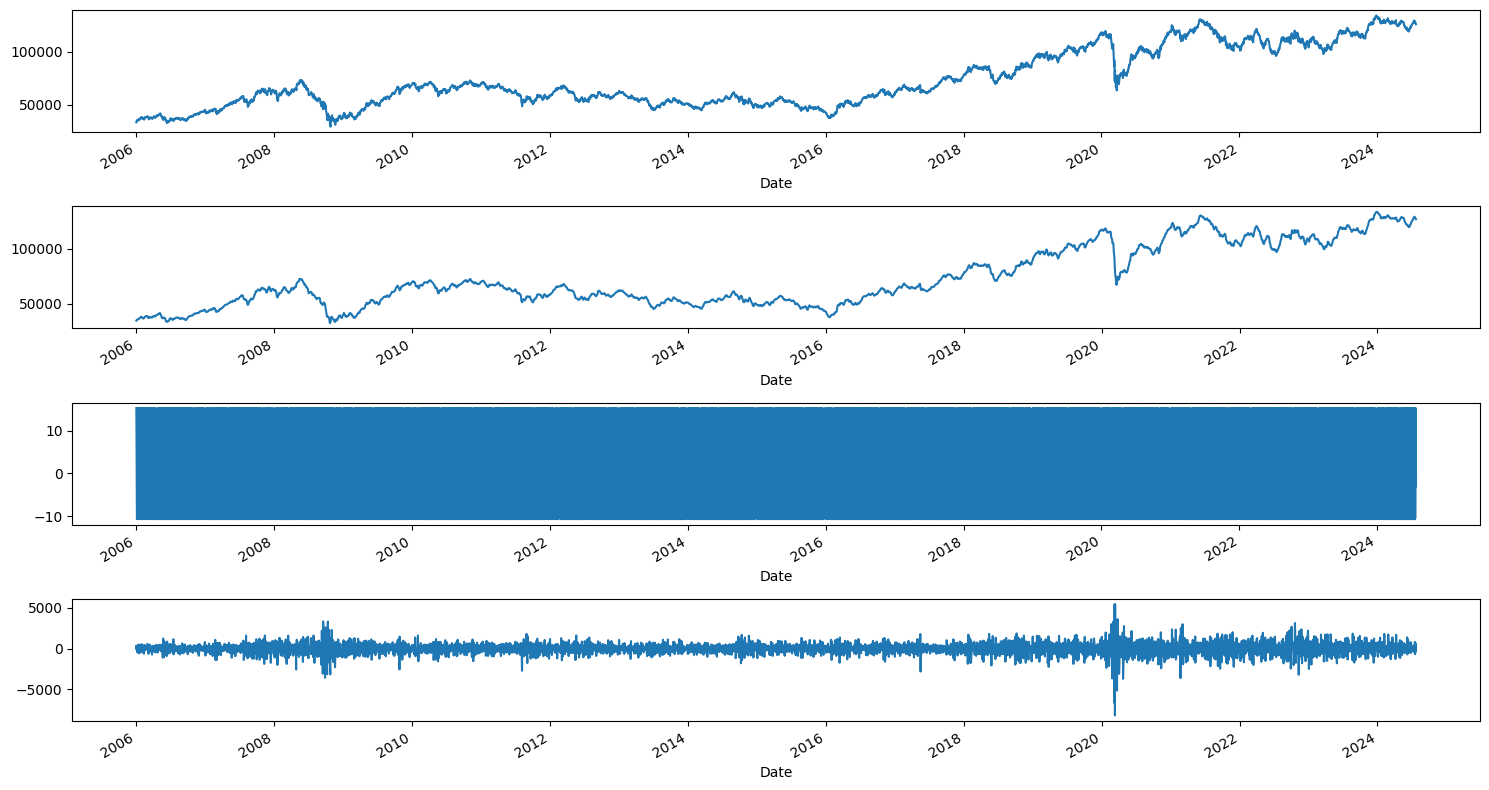

In [962]:
dec = seasonal_decompose(df, period = 5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
dec.observed.plot(ax=ax1)
dec.trend.plot(ax=ax2)
dec.seasonal.plot(ax=ax3)
dec.resid.plot(ax=ax4)
plt.tight_layout()

Para confirmar nossas suspeitas em relação à não-estacionaridade da série temporal, podemos realizar o teste ADF, verificando marcadores estatísticos como o P valor.

De acordo com nosso teste, podemos confirmar nossa tese de que esta não é uma série estacionária.

In [963]:
x = df.Close.values

ADF_result = adfuller(x)

print('ADF Test')
print(f"Statistical test: {ADF_result[0]}")
print(f"P-value: {ADF_result[1]}")
print('Critical Values:')

for key, value in ADF_result[4].items():
  print(f"\t{key}: {value}")

ADF Test
Statistical test: -1.1777500962285268
P-value: 0.6830930883708923
Critical Values:
	1%: -3.431777971900744
	5%: -2.8621709964988606
	10%: -2.5671058823769246


À partir desta informação podemos iniciar uma série de transformações na série temporal à fim de torná=la estacionária.

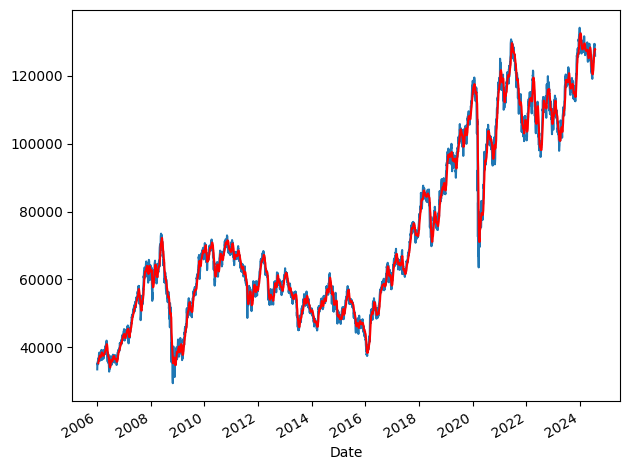

In [964]:
ma12 = df.rolling(12).mean()

f, ax = plt.subplots()

df.plot(ax=ax, legend=False)
ma12.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

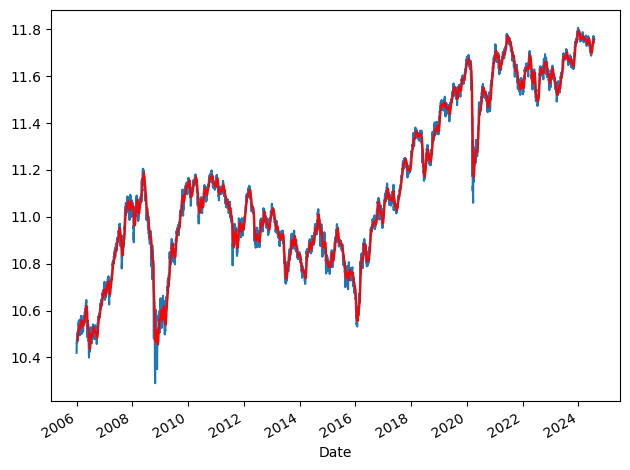

In [965]:
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()

df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

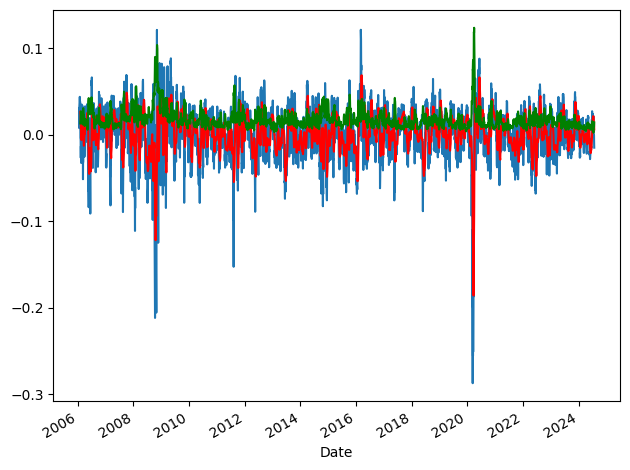

In [966]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()
plt.show()

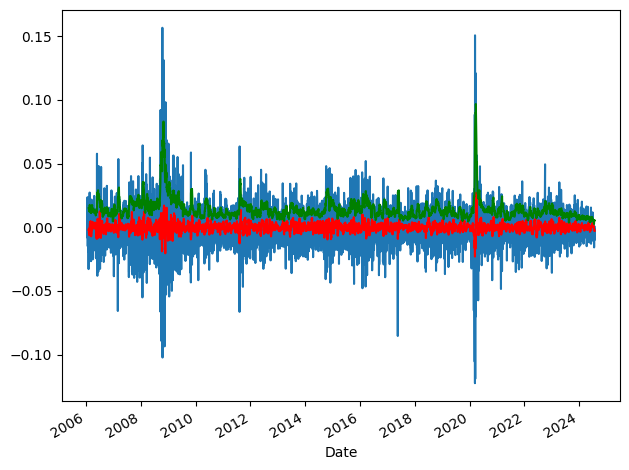

In [967]:
df_diff = df_s.diff(1)

ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()
plt.show()

Após a aplicação de médias móveis e diferenciações, chegamos a uma série temporal cujo P Value no teste ADF é 0.0, ou seja: temos uma série estacionária.

In [968]:
x_diff = df_diff.Close.dropna().values

result_diff = adfuller(x_diff)

print('ADF Test')
print(f"Statistical test: {result_diff[0]}")
print(f"P-value: {result_diff[1]}")
print('Critical Values:')

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

ADF Test
Statistical test: -18.94581175293611
P-value: 0.0
Critical Values:
	1%: -3.431788020454428
	5%: -2.8621754357106632
	10%: -2.567108245574206


# Forecasting

Neste momento podemos iniciar a aplicação de modelos preditivos para realizar o forecasting dos resultados do IBOVESPA. Para fins deste relatório, testaremos 4 modelos diferentes de forecasting: Naive, SeasonalNaive, AutoARIMA e Prophet.

Iniciamos essa etapa preparando a série temporal para passar pelos modelos. Incluímos os dias de fim de semana, os quais não estavam originalmente no relatório da bolsa, e aplicamos o valor de fechamento de sexta-feira para estes dias. Esse processo visa evitar gaps e defasegem nos modelos que requerem datas contínuas.

Também ajustamos os nomes de columnas tanto para os modelos do StatsForecast quanto para o Prophet.

In [988]:
SForecast_df = df
start = SForecast_df.index[0].date()

end = SForecast_df.index[len(SForecast_df)-1].date()

new_dates = pd.date_range(start=start,end=end,freq='D')

SForecast_df = SForecast_df.reindex(new_dates)

SForecast_df = SForecast_df.rename_axis('ds')

SForecast_df = SForecast_df.reset_index('ds')
SForecast_df.insert(1, 'unique_id', '^BVSP')
SForecast_df = SForecast_df.rename(columns = {'Date': 'ds', 'Close':'y'})

SForecast_df = SForecast_df.fillna(method = 'ffill')
SForecast_df.head(10)

<ipython-input-988-28b5585c3945>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SForecast_df = SForecast_df.fillna(method = 'ffill')


,ds,unique_id,y
0,2006-01-02,^BVSP,33507.0
1,2006-01-03,^BVSP,34541.0
2,2006-01-04,^BVSP,35002.0
3,2006-01-05,^BVSP,34936.0
4,2006-01-06,^BVSP,35475.0
5,2006-01-07,^BVSP,35475.0
6,2006-01-08,^BVSP,35475.0
7,2006-01-09,^BVSP,35337.0
8,2006-01-10,^BVSP,35049.0
9,2006-01-11,^BVSP,35952.0


In [989]:
train = SForecast_df.loc[SForecast_df['ds'] < '2023-07-01']

valid = SForecast_df.loc[(SForecast_df['ds'] >= '2023-07-01') & (SForecast_df['ds'] < '2024-07-26')]

h = valid['ds'].nunique()

h

391

In [990]:
def wmape(y_true, y_pred):
  return np.abs(y_true - y_pred).sum()/np.abs(y_true).sum()

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE:  5.35%


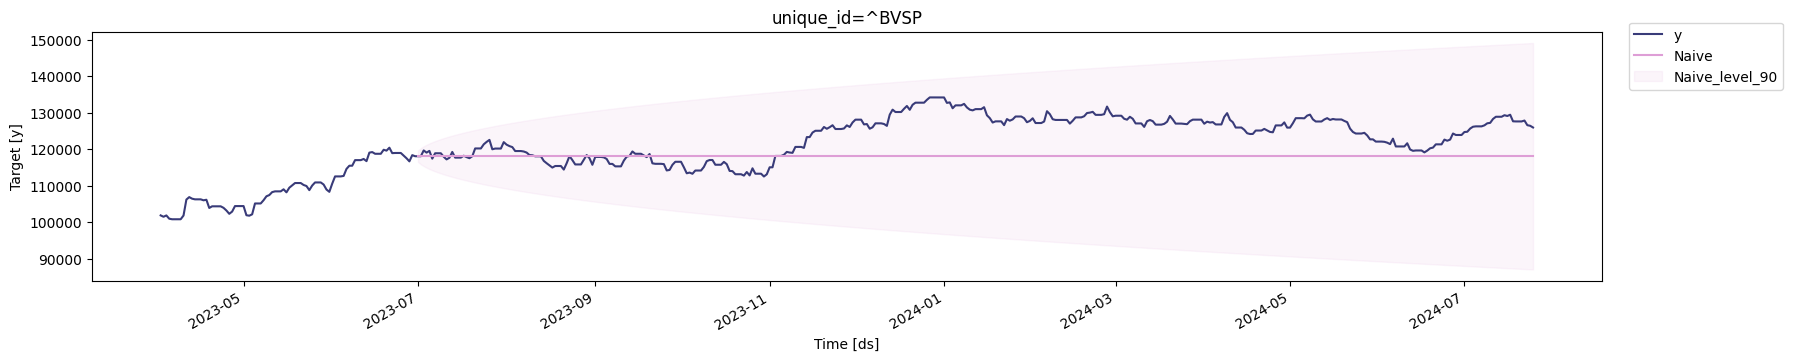

In [991]:
model_naive = StatsForecast(models=[Naive()], freq= 'D', n_jobs = -1)
model_naive.fit(train)

forecast_df = model_naive.predict(h=h, level = [90])

forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape_var = wmape(forecast_df['y'].values, forecast_df['Naive'].values)

print(f'WMAPE: {wmape_var: .2%}')

model_naive.plot(train, forecast_df, level=[90], unique_ids=['^BVSP'], engine='matplotlib', max_insample_length=90)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE:  5.37%


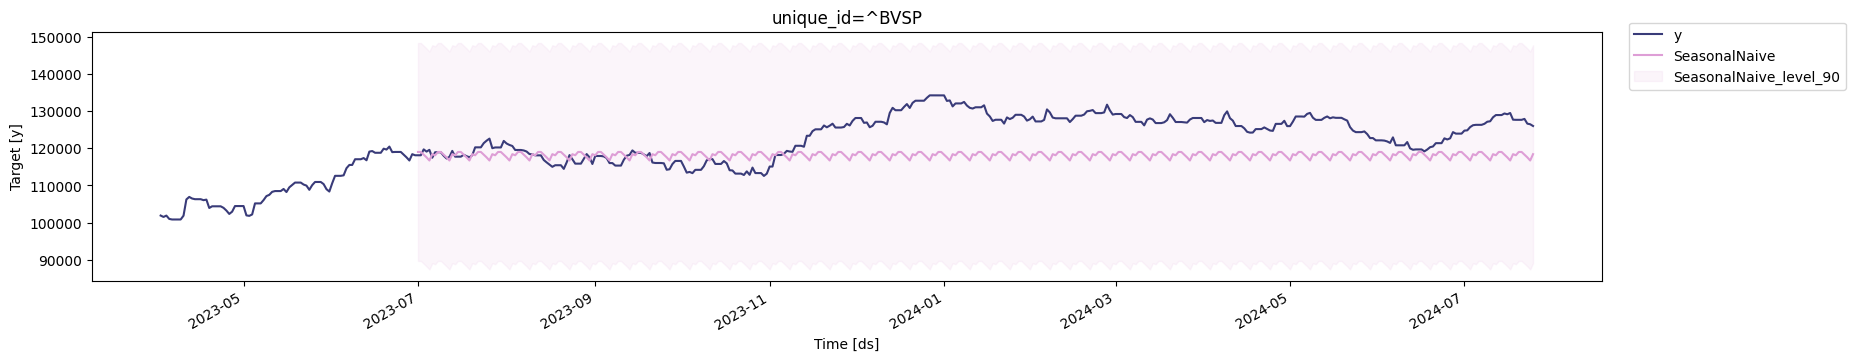

In [975]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs = -1)
model_s.fit(train)

forecast_df_s = model_s.predict(h=h, level = [90])

forecast_df_s = forecast_df_s.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape_var_s = wmape(forecast_df_s['y'].values, forecast_df_s['SeasonalNaive'].values)

print(f'WMAPE: {wmape_var_s: .2%}')

model_s.plot(train, forecast_df_s, level=[90], unique_ids=['^BVSP'], engine='matplotlib', max_insample_length=90)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE:  5.34%


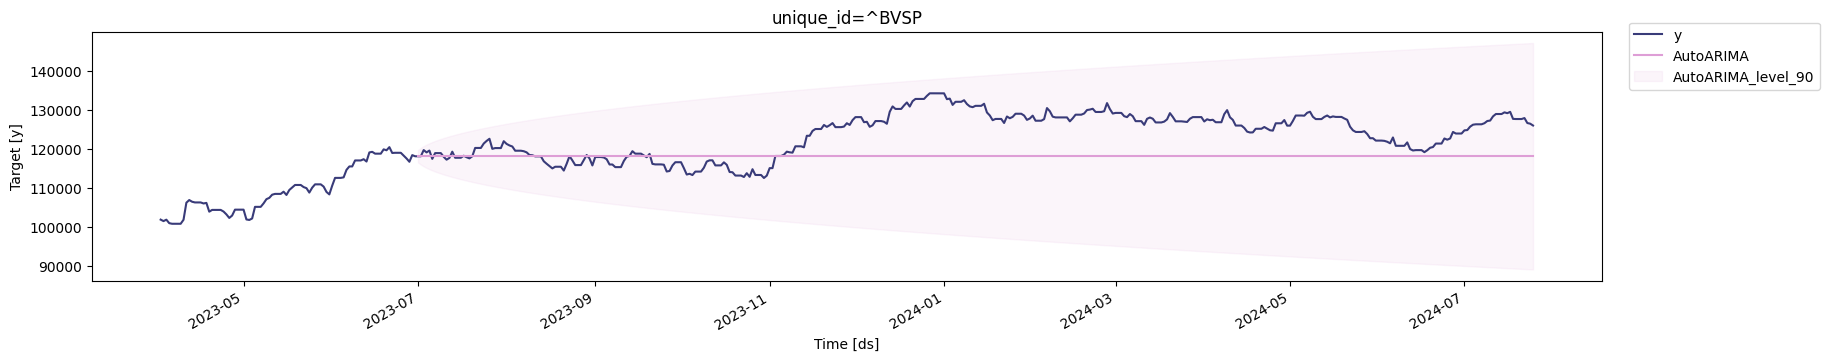

In [977]:
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs = -1)
model_a.fit(train)

forecast_a = model_a.predict(h=h, level = [90])

forecast_a = forecast_a.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape_vara = wmape(forecast_a['y'].values, forecast_a['AutoARIMA'].values)

print(f'WMAPE: {wmape_vara: .2%}')

model_a.plot(train, forecast_a, level = [90], unique_ids=['^BVSP'], engine='matplotlib', max_insample_length=90)

In [978]:
prophet_df = df.reset_index('Date')
prophet_df['Date'] = pd.to_datetime(prophet_df['Date'])
prophet_df[['ds','y']] = prophet_df[['Date','Close']]
prophet_df.head()

,Date,Close,ds,y
0,2006-01-02,33507.0,2006-01-02,33507.0
1,2006-01-03,34541.0,2006-01-03,34541.0
2,2006-01-04,35002.0,2006-01-04,35002.0
3,2006-01-05,34936.0,2006-01-05,34936.0
4,2006-01-06,35475.0,2006-01-06,35475.0


In [979]:
train = newdf.sample(frac=0.8, random_state=0)
test = newdf.drop(train.index)
print(f'training data size : {train.shape}')
print(f'testing data size : {test.shape}')

training data size : (3674, 4)
testing data size : (919, 4)


In [980]:
model = Prophet(daily_seasonality=True)
model.fit(train)
dataFramefuture = model.make_future_dataframe(periods=30, freq='D')
pred = model.predict(dataFramefuture)
pred.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk206w2gx/anr8_zt1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk206w2gx/squu5ae6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43927', 'data', 'file=/tmp/tmpk206w2gx/anr8_zt1.json', 'init=/tmp/tmpk206w2gx/squu5ae6.json', 'output', 'file=/tmp/tmpk206w2gx/prophet_modelh77s6jkg/prophet_model-20240730041356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:13:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:14:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-01-03,33490.662386,24622.840929,41228.545530,33490.662386,33490.662386,-480.763498,-480.763498,-480.763498,-2008.197107,...,-59.864259,-59.864259,-59.864259,1587.297867,1587.297867,1587.297867,0.0,0.0,0.0,33009.898888
1,2006-01-04,33531.321109,24094.206869,40475.451814,33531.321109,33531.321109,-618.283919,-618.283919,-618.283919,-2008.197107,...,-228.232052,-228.232052,-228.232052,1618.145240,1618.145240,1618.145240,0.0,0.0,0.0,32913.037190
2,2006-01-05,33571.979832,25133.922179,41260.007778,33571.979832,33571.979832,-249.138806,-249.138806,-249.138806,-2008.197107,...,115.241942,115.241942,115.241942,1643.816358,1643.816358,1643.816358,0.0,0.0,0.0,33322.841026
3,2006-01-06,33612.638555,24752.750545,41268.276616,33612.638555,33612.638555,-423.475510,-423.475510,-423.475510,-2008.197107,...,-79.488704,-79.488704,-79.488704,1664.210301,1664.210301,1664.210301,0.0,0.0,0.0,33189.163045
4,2006-01-09,33734.614724,24894.170738,41410.287270,33734.614724,33734.614724,-563.682714,-563.682714,-563.682714,-2008.197107,...,-249.705982,-249.705982,-249.705982,1694.220374,1694.220374,1694.220374,0.0,0.0,0.0,33170.932009


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


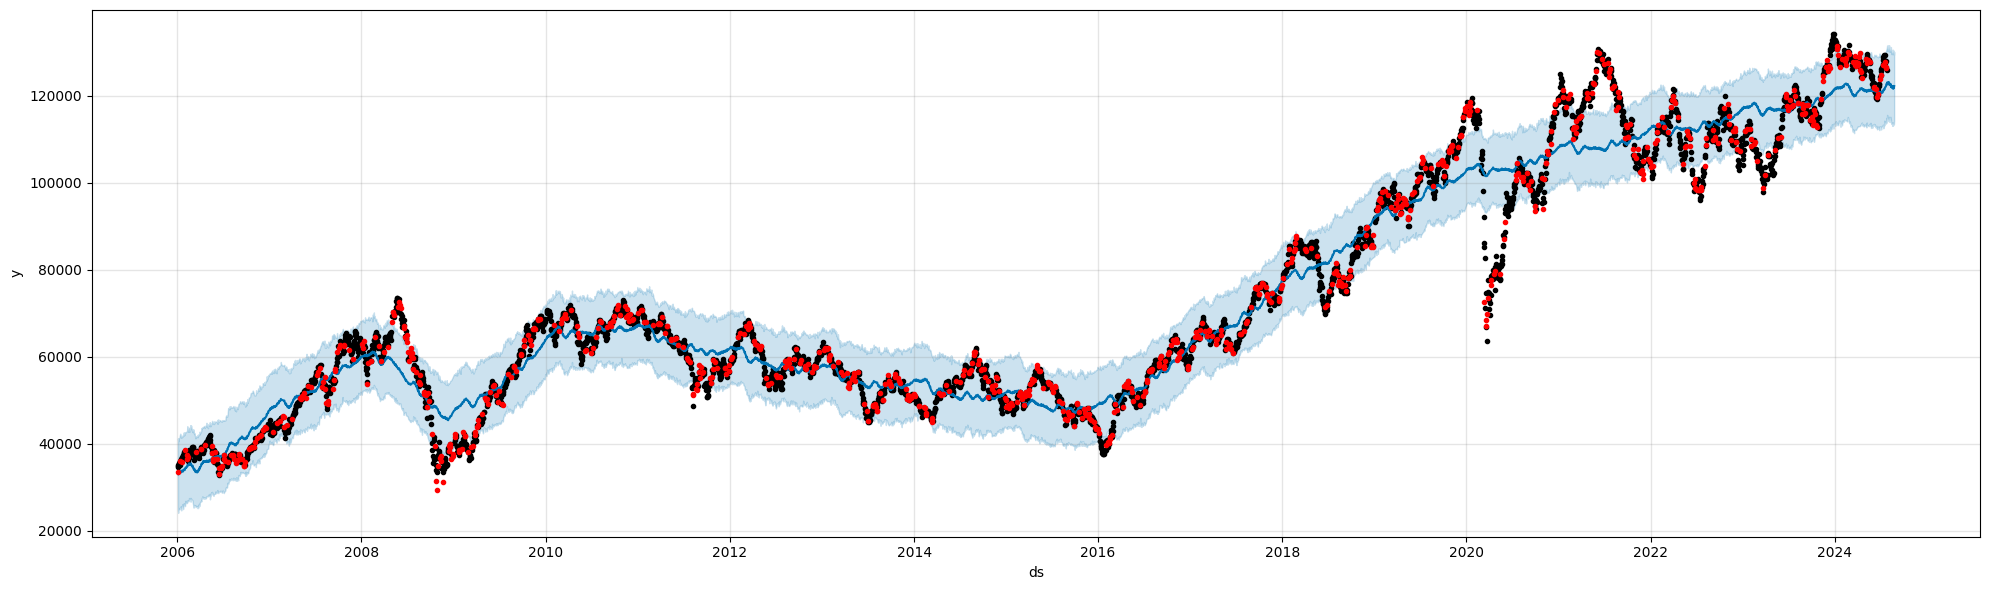

In [981]:
model.plot(pred, figsize=(20,6));
plt.plot(test['ds'], test['y'], '.r')

In [982]:
pred_select = ['ds', 'yhat']
valid_select = ['ds', 'y']

pred = pred[pred_select]
valid = train[valid_select]

results = pd.merge(pred, valid, on='ds', how='inner')

wmape_prophet = wmape(results['y'].values,  results['yhat'].values)
print(f"WMAPE: {wmape_prophet:.2f}%")

#results['abs_percent_error'] = np.abs((results['y'] - results['yhat']) / results['y']) * 100

#mape = np.mean(results['abs_percent_error'])

#print(f"MAPE: {mape:.2f}%")

WMAPE: 0.06%


# Conclusão

Todos os 4 modelos testados performaram bem, tendo um resultado no WMAPE (Weighted Mean Absolute Percentage Error) que indica mais de 90% de acertos. O grande vencedor, no entanto, foi o Prophet, modelo preditivo da META, WMAPE de 0,06%. Uma explicação para esse resultado é que o Prophet foi desenvolvido com foco em dados com altas variações e seu modelo é robusto o suficiente para lidar com dados faltantes, como finais de semana e feriados.

Com estes resultados em vista, podemos cravar o Prophet como a melhor sugestão para o forecasting de dados da IBOVESPA, seguido pelo modelo AutoARIMA (WMAPE = 5,34%). No entanto, é preciso salientar a necessidade de outras informações qualitativas para a real avaliação do desempenho da Bolsa de Valores, como a situação geopolítica do mundo, eventos mundiais e flutuações de outros ativos, como câmbio e outras bolsas.